<a href="https://colab.research.google.com/github/jamdebricassart/Project/blob/main/%D0%A1%D0%B1%D0%BE%D1%80%D0%BD%D1%8B%D0%B9_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.



In [1]:
pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Импортируем все необходимые для работы бибиотеки и инструменты

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
import ntpath
import time
import os, os.path
import matplotlib.pyplot as plt
import re
import transformers
from pathlib import Path
import tensorflow as tf

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tqdm import notebook
from tqdm import tqdm
from torchvision import transforms
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import  LinearRegression
from sklearn.metrics import mean_squared_error
from PIL import Image
from warnings import simplefilter
from sklearn.decomposition import PCA
import matplotlib.image as mpimg

simplefilter(action='ignore', category=FutureWarning)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from transformers import TFAutoModel, AutoTokenizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout


In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Пропишем путь ко всем необходимым папкам и файлам

In [5]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/to_upload/train_dataset.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/to_upload/test_queries.csv'
CROWD_ANNOTATIONS_PATH = '/content/drive/MyDrive/to_upload/CrowdAnnotations.tsv'
EXPERT_ANNOTATIONS_PATH = '/content/drive/MyDrive/to_upload/ExpertAnnotations.tsv'
TRAIN_IMAGES_PATH = '/content/drive/MyDrive/to_upload/train_images'
TEST_IMAGES_PATH = '/content/drive/MyDrive/to_upload/test_images.csv'
TMP='./cache'
DATA_PATH = '/content/drive/MyDrive/to_upload'

## 1. Исследовательский анализ данных


Загрузим и с помощью «джентельменского набора» первично изучим датасеты




В файле train_dataset.csv собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания.

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
display(train_df.head())
train_df.info()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [7]:
print('Полных дубликатов:', train_df.duplicated().sum())
print('Дубликатов среди колонок:', train_df.duplicated(subset = ['image', 'query_id']).sum())

Полных дубликатов: 0
Дубликатов среди колонок: 0


В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний.

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep = '|', index_col = 0)
display(test_df.head())
test_df.info()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [9]:
print('Полных дубликатов:', test_df.duplicated().sum())
print('Дубликатов среди колонок:', test_df.duplicated(subset = ['image', 'query_text']).sum())

Полных дубликатов: 0
Дубликатов среди колонок: 0


В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- Доля людей, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание не соответствует изображению.

In [10]:
crowd_df = pd.read_csv(
    CROWD_ANNOTATIONS_PATH,
    sep = '\t',
    header = None,
    names = ['image', 'query_id', 'positive', 'double_positive', 'negative']
)
display(crowd_df.head())
crowd_df.info()

,image,query_id,positive,double_positive,negative
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   query_id         47830 non-null  object 
 2   positive         47830 non-null  float64
 3   double_positive  47830 non-null  int64  
 4   negative         47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [11]:
print('Полных дубликатов:', crowd_df.duplicated().sum())
print('Дубликатов среди колонок:', crowd_df.duplicated(subset = ['image', 'query_id']).sum())

Полных дубликатов: 0
Дубликатов среди колонок: 0


В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- 3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

In [12]:
expert_df = pd.read_csv(
    EXPERT_ANNOTATIONS_PATH,
    sep = '\t',
    header = None,
    names = ['image', 'query_id', 'exp_1', 'exp_2', 'exp_3']
)
display(expert_df.head())
expert_df.info()

,image,query_id,exp_1,exp_2,exp_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [13]:
print('Полных дубликатов:', expert_df.duplicated().sum())
print('Дубликатов среди колонок:', expert_df.duplicated(subset = ['image', 'query_id']).sum())

Полных дубликатов: 0
Дубликатов среди колонок: 0


In [14]:
test_images = pd.read_csv(TEST_IMAGES_PATH)
display(test_images.head())
test_images.info()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


Приступим к объединению таблиц для создания общего датасета, который будет одержать фото и его оценку из разных источников. Объединять будем по image	и query_id, которые идентичны во всех датасетах.

In [15]:
crowd_df['mark'] = crowd_df['positive']
crowd_df = crowd_df.drop((['positive', 'double_positive', 'negative']), axis=1)
crowd_df.columns = ['image', 'query_id', 'mark']
crowd_df.head(5)

,image,query_id,mark
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0


In [16]:
cols = ['exp_1', 'exp_2', 'exp_3']
for col in cols:

    expert_df[col] = expert_df[col].apply(lambda x: 0 if x == 1 else x)
    expert_df[col] = expert_df[col].apply(lambda x: 0.33 if x == 2 else x)
    expert_df[col] = expert_df[col].apply(lambda x: 0.67 if x == 3 else x)
    expert_df[col] = expert_df[col].apply(lambda x: 1 if x == 4 else x)

expert_df['mark'] = (expert_df['exp_1'] + expert_df['exp_2'] + expert_df['exp_3']) / 3
expert_df = expert_df.drop((['exp_1', 'exp_2', 'exp_3']), axis=1)
expert_df.columns = ['image', 'query_id', 'mark']

expert_df.head(5)

,image,query_id,mark
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.00
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.11
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.11
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.22
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.11


In [17]:
df = train_df.merge(crowd_df, on=['image', 'query_id'], suffixes=('', '_y'), how='inner')
df.sample(15)

,image,query_id,query_text,mark
273,3100251515_c68027cc22.jpg,1174629344_a2e1a2bdbf.jpg#2,A group of people walking a city street in war...,0.0
1755,2718495608_d8533e3ac5.jpg,3503689049_63212220be.jpg#2,a young man wearing dark sunglasses smiling,0.0
1417,2599444370_9e40103027.jpg,1392272228_cf104086e6.jpg#2,A black dog is coming out of the ocean water o...,0.0
1604,2120383553_5825333a3f.jpg,3564312955_716e86c48b.jpg#2,a smiling toddler in a pink swimsuit is laying...,0.0
693,229862312_1a0ba19dab.jpg,2862004252_53894bb28b.jpg#2,A brown and tan dog walks through the green gr...,0.0
1479,2878190821_6e4e03dc5f.jpg,2458269558_277012780d.jpg#2,A child is smiling while being on a swing .,0.0
2248,470373679_98dceb19e7.jpg,470373679_98dceb19e7.jpg#2,People look out the window at mountains .,1.0
2077,3115174046_9e96b9ce47.jpg,2431470169_0eeba7d602.jpg#2,Man reading a newspaper at an outdoors restaur...,0.0
1785,2346401538_f5e8da66fc.jpg,3121521593_18f0ec14f7.jpg#2,"Two girls , one wearing glasses , dressed in c...",0.0
1575,2577972703_a22c5f2a87.jpg,2436081047_bca044c1d3.jpg#2,A little girl wearing a pink shirt jumps off a...,0.2


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       2329 non-null   object 
 1   query_id    2329 non-null   object 
 2   query_text  2329 non-null   object 
 3   mark        2329 non-null   float64
dtypes: float64(1), object(3)
memory usage: 91.0+ KB


In [19]:
df = expert_df.merge(train_df, on=['image', 'query_id'], suffixes=('', '_y'), how='inner')
df.head(5)

,image,query_id,mark,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.00,A young child is wearing blue goggles and sitt...
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.11,A girl wearing a yellow shirt and sunglasses s...
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.11,A man sleeps under a blanket on a city street .
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.22,A woman plays with long red ribbons in an empt...
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.11,Chinese market street in the winter time .


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   mark        5822 non-null   float64
 3   query_text  5822 non-null   object 
dtypes: float64(1), object(3)
memory usage: 227.4+ KB


In [21]:
mark_df = pd.DataFrame(train_df['image'])
mark_df['query_id'] = mark_df['image'] + '#2'
mark_df['mark'] = 1
mark_df= mark_df.merge(train_df[['query_id', 'query_text']], on=['query_id'], suffixes=('', '_y'), how='inner').drop_duplicates(ignore_index=True)
mark_df = mark_df[['image', 'query_id', 'query_text', 'mark']]

In [22]:
crowed_df = crowd_df.merge(train_df[['query_text', 'query_id']], on='query_id').drop_duplicates(ignore_index=True)
crowed_df = crowed_df[['image', 'query_id', 'query_text', 'mark']]
crowed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46721 entries, 0 to 46720
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       46721 non-null  object 
 1   query_id    46721 non-null  object 
 2   query_text  46721 non-null  object 
 3   mark        46721 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


In [23]:
df = pd.concat([mark_df, df, crowed_df], axis = 0).drop_duplicates(ignore_index=True)
df.head(3)

,image,query_id,query_text,mark
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.0
1,1262583859_653f1469a9.jpg,1262583859_653f1469a9.jpg#2,A man in a bright green shirt riding a bicycle...,1.0
2,2447284966_d6bbdb4b6e.jpg,2447284966_d6bbdb4b6e.jpg#2,A young boy in a team sweatshirt is in a sport...,1.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       52441 non-null  object 
 1   query_id    52441 non-null  object 
 2   query_text  52441 non-null  object 
 3   mark        52441 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


In [25]:
print('Пропусков:', df.isnull().sum())

Пропусков: image         0
query_id      0
query_text    0
mark          0
dtype: int64


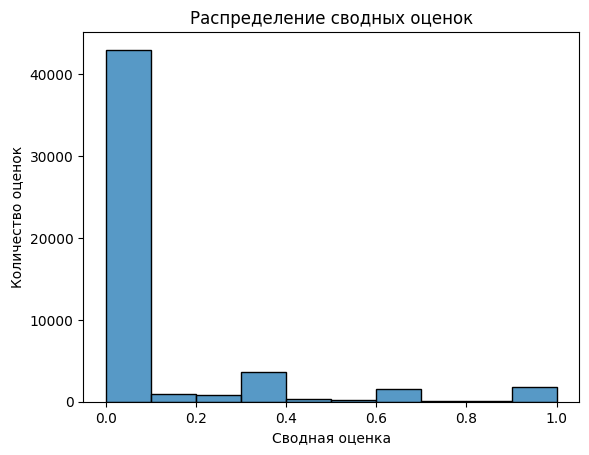

In [26]:
sns.histplot(df['mark'], bins = 10)
plt.xlabel('Сводная оценка')
plt.ylabel('Количество оценок')
plt.title('Распределение сводных оценок')
plt.show()

Мы получили датасет, в котором преобладают нулевые оценки экспертов.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

In [27]:
block_words = ['child',
             'children',
             'baby',
             'babies',
             'boy',
             'boys',
             'girl',
             'girls',
             'kid',
             'kids',
             'infant',
             'infants',
             'toddler',
             'toddlers'
             'young',
             'teen',
             'teenager',
             'stripling']

In [28]:
block_list_index = []
for word in block_words:
  block_text = df.query_text.str.contains(word, case=False)
  block_list_index += df[block_text].index.tolist()
block_list = df.iloc[block_list_index].query_id.apply(lambda x: x.split('#')[0]).unique()

In [29]:
len(block_list_index)

20014

In [30]:
len(block_list)

294

In [31]:
df_filtered = df.loc[df.image.isin(block_list) == False]
df_filtered.reset_index(inplace=True)

In [32]:
df_filtered.info()
display(df_filtered.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37334 entries, 0 to 37333
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       37334 non-null  int64  
 1   image       37334 non-null  object 
 2   query_id    37334 non-null  object 
 3   query_text  37334 non-null  object 
 4   mark        37334 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.4+ MB


,index,image,query_id,query_text,mark
0,0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.0
1,1,1262583859_653f1469a9.jpg,1262583859_653f1469a9.jpg#2,A man in a bright green shirt riding a bicycle...,1.0
2,4,2621415349_ef1a7e73be.jpg,2621415349_ef1a7e73be.jpg#2,A man wearing sunglasses and a red cap putting...,1.0
3,6,3155451946_c0862c70cb.jpg,3155451946_c0862c70cb.jpg#2,Three basketball players leap to grab a ball .,1.0
4,7,3222041930_f642f49d28.jpg,3222041930_f642f49d28.jpg#2,"A man is standing up , reading a newspaper , a...",1.0


Данные, попадающие под юридические ограничения, были удалены из датасета.

## 3. Векторизация изображений

In [33]:
df_train_images = pd.DataFrame(df_filtered.image.unique(), columns=['image'])
df_train_images

,image
0,1056338697_4f7d7ce270.jpg
1,1262583859_653f1469a9.jpg
2,2621415349_ef1a7e73be.jpg
3,3155451946_c0862c70cb.jpg
4,3222041930_f642f49d28.jpg
...,...
701,3427118504_93126c83e0.jpg
702,3499720588_c32590108e.jpg
703,3521374954_37371b49a4.jpg
704,3523559027_a65619a34b.jpg


In [34]:
datagen_train = ImageDataGenerator(rescale=1.0/255)

train_datagen_flow = datagen_train.flow_from_dataframe(
    dataframe = df_train_images,
    directory = os.path.join(DATA_PATH, 'train_images'),
    x_col='image',
    target_size=(224, 224),
    class_mode=None,
    batch_size=24,
    shuffle=True,
    seed=1
)

Found 706 validated image filenames.


In [35]:
backbone = ResNet50(weights='imagenet',
                    include_top=False)
backbone.trainable = False

In [36]:
%%time
model_image = Sequential()
model_image.add(backbone)
model_image.add(GlobalAveragePooling2D())

image_features = model_image.predict(train_datagen_flow)

30/30 [==============================] - 187s 6s/step
CPU times: user 3min 38s, sys: 34.7 s, total: 4min 13s
Wall time: 3min 27s


In [37]:
len(image_features[0])

2048

In [38]:
df_train_images = pd.concat([df_train_images, pd.DataFrame(image_features)], axis=1)

In [39]:
df_train_images.head()

,image,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1056338697_4f7d7ce270.jpg,0.0,0.0,0.021941,0.0,1.270019,0.0,0.0,1.028748,0.014550,...,0.0,0.0,0.0,0.0,0.017313,0.0,0.0,1.793972,0.0,0.0
1,1262583859_653f1469a9.jpg,0.0,0.0,0.000000,0.0,1.255351,0.0,0.0,0.795950,0.046744,...,0.0,0.0,0.0,0.0,0.026202,0.0,0.0,2.417506,0.0,0.0
2,2621415349_ef1a7e73be.jpg,0.0,0.0,0.001260,0.0,1.272532,0.0,0.0,0.950721,0.008803,...,0.0,0.0,0.0,0.0,0.033453,0.0,0.0,1.851108,0.0,0.0
3,3155451946_c0862c70cb.jpg,0.0,0.0,0.002250,0.0,0.847834,0.0,0.0,0.911806,0.000000,...,0.0,0.0,0.0,0.0,0.013827,0.0,0.0,1.942049,0.0,0.0
4,3222041930_f642f49d28.jpg,0.0,0.0,0.000862,0.0,1.339392,0.0,0.0,0.894783,0.030007,...,0.0,0.0,0.0,0.0,0.033415,0.0,0.0,1.941482,0.0,0.0


In [40]:
df_train_images.shape

(706, 2049)

Сделали векторизацию изображений с помощью ResNet50.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- трансформеры

In [41]:
df_train_text = df_filtered[['query_id', 'query_text']]

In [42]:
df_train_text.head()

,query_id,query_text
0,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f..."
1,1262583859_653f1469a9.jpg#2,A man in a bright green shirt riding a bicycle...
2,2621415349_ef1a7e73be.jpg#2,A man wearing sunglasses and a red cap putting...
3,3155451946_c0862c70cb.jpg#2,Three basketball players leap to grab a ball .
4,3222041930_f642f49d28.jpg#2,"A man is standing up , reading a newspaper , a..."


In [43]:
model = TFAutoModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [44]:
df_filtered.query_text.map(lambda x: len(x)).max()

153

In [45]:
SEQ_LEN = 50

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=False, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

Xids = np.zeros((len(df_filtered.query_text), SEQ_LEN))
Xmask = np.zeros((len(df_filtered.query_text), SEQ_LEN))

for i, sentence in enumerate(df_filtered['query_text']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)

In [46]:
input_ids = tf.keras.layers.Input(shape=(Xids.shape[0],), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(Xids.shape[0],), name='attention_mask', dtype='int32')

embeddings = model(input_ids, attention_mask=mask)[0]

In [47]:
embeddings

<KerasTensor: shape=(None, 37334, 768) dtype=float32 (created by layer 'tf_bert_model')>

In [48]:
vectorizer = TfidfVectorizer()
matrix_tfidf = vectorizer.fit_transform(df_filtered['query_text']).toarray()
matrix_tfidf.shape

(37334, 1510)

In [49]:
df_tfidf = pd.DataFrame(matrix_tfidf)
df_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
df_train_text = df_train_text.join(df_tfidf)
df_train_text.head()

,query_id,query_text,0,1,2,3,4,5,6,7,...,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509
0,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1262583859_653f1469a9.jpg#2,A man in a bright green shirt riding a bicycle...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2621415349_ef1a7e73be.jpg#2,A man wearing sunglasses and a red cap putting...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3155451946_c0862c70cb.jpg#2,Three basketball players leap to grab a ball .,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3222041930_f642f49d28.jpg#2,"A man is standing up , reading a newspaper , a...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Выполнена векторизация описаний с использованием модели BERT.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.


In [51]:
data = df_filtered.merge(df_train_images, on='image')
data = data.drop(['index'], axis=1)

In [52]:
data

,image,query_id,query_text,mark,0,1,2,3,4,5,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.000000,0.0,0.0,0.021941,0.0,1.270019,0.0,...,0.0,0.0,0.0,0.0,0.017313,0.0,0.0,1.793972,0.0,0.0
1,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,0.0,0.021941,0.0,1.270019,0.0,...,0.0,0.0,0.0,0.0,0.017313,0.0,0.0,1.793972,0.0,0.0
2,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.110000,0.0,0.0,0.021941,0.0,1.270019,0.0,...,0.0,0.0,0.0,0.0,0.017313,0.0,0.0,1.793972,0.0,0.0
3,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.110000,0.0,0.0,0.021941,0.0,1.270019,0.0,...,0.0,0.0,0.0,0.0,0.017313,0.0,0.0,1.793972,0.0,0.0
4,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,0.220000,0.0,0.0,0.021941,0.0,1.270019,0.0,...,0.0,0.0,0.0,0.0,0.017313,0.0,0.0,1.793972,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37329,86412576_c53392ef80.jpg,1461667284_041c8a2475.jpg#2,A man in a white hat plays guitar on a stage .,0.000000,0.0,0.0,0.000000,0.0,1.418840,0.0,...,0.0,0.0,0.0,0.0,0.024558,0.0,0.0,2.299194,0.0,0.0
37330,86412576_c53392ef80.jpg,2708686056_1b8f356264.jpg#2,A woman walking into the waves .,0.000000,0.0,0.0,0.000000,0.0,1.418840,0.0,...,0.0,0.0,0.0,0.0,0.024558,0.0,0.0,2.299194,0.0,0.0
37331,86412576_c53392ef80.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,0.333333,0.0,0.0,0.000000,0.0,1.418840,0.0,...,0.0,0.0,0.0,0.0,0.024558,0.0,0.0,2.299194,0.0,0.0
37332,86412576_c53392ef80.jpg,3578841731_f775cab089.jpg#2,a red and white race car racing on a dirt race...,0.000000,0.0,0.0,0.000000,0.0,1.418840,0.0,...,0.0,0.0,0.0,0.0,0.024558,0.0,0.0,2.299194,0.0,0.0


In [53]:
df_train_text.head()

,query_id,query_text,0,1,2,3,4,5,6,7,...,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509
0,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1262583859_653f1469a9.jpg#2,A man in a bright green shirt riding a bicycle...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2621415349_ef1a7e73be.jpg#2,A man wearing sunglasses and a red cap putting...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3155451946_c0862c70cb.jpg#2,Three basketball players leap to grab a ball .,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3222041930_f642f49d28.jpg#2,"A man is standing up , reading a newspaper , a...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
df = data.merge(df_train_text, left_index=True, right_index=True, suffixes=(None, '_t'))
df = df.drop(['query_id_t', 'query_text_t'], axis=1)
df

,image,query_id,query_text,mark,0,1,2,3,4,5,...,1500_t,1501_t,1502_t,1503_t,1504_t,1505_t,1506_t,1507_t,1508_t,1509_t
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.000000,0.0,0.0,0.021941,0.0,1.270019,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,0.0,0.0,0.021941,0.0,1.270019,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.110000,0.0,0.0,0.021941,0.0,1.270019,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.110000,0.0,0.0,0.021941,0.0,1.270019,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,0.220000,0.0,0.0,0.021941,0.0,1.270019,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37329,86412576_c53392ef80.jpg,1461667284_041c8a2475.jpg#2,A man in a white hat plays guitar on a stage .,0.000000,0.0,0.0,0.000000,0.0,1.418840,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37330,86412576_c53392ef80.jpg,2708686056_1b8f356264.jpg#2,A woman walking into the waves .,0.000000,0.0,0.0,0.000000,0.0,1.418840,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37331,86412576_c53392ef80.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,0.333333,0.0,0.0,0.000000,0.0,1.418840,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37332,86412576_c53392ef80.jpg,3578841731_f775cab089.jpg#2,a red and white race car racing on a dirt race...,0.000000,0.0,0.0,0.000000,0.0,1.418840,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Итоговый датасет содержит 37334 строк и 3562 столбцов.

## 6. Обучение модели предсказания соответствия

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

In [55]:
gss = GroupShuffleSplit(n_splits = 1, train_size=0.7, random_state=1)
train_idx, valid_idx = next(gss.split(X=df.drop(columns=['image', 'mark', 'query_id',
                                                                       'query_text']),
                                     y=df['mark'],
                                     groups=df['image']))
train, valid = df.loc[train_idx], df.loc[valid_idx]

In [56]:
train.head()

,image,query_id,query_text,mark,0,1,2,3,4,5,...,1500_t,1501_t,1502_t,1503_t,1504_t,1505_t,1506_t,1507_t,1508_t,1509_t
114,2621415349_ef1a7e73be.jpg,2621415349_ef1a7e73be.jpg#2,A man wearing sunglasses and a red cap putting...,1.00,0.0,0.0,0.00126,0.0,1.272532,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115,2621415349_ef1a7e73be.jpg,143688283_a96ded20f1.jpg#2,A man in a white shirt and helmet is using cli...,0.11,0.0,0.0,0.00126,0.0,1.272532,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,2621415349_ef1a7e73be.jpg,2396691909_6b8c2f7c44.jpg#2,A young girl with makeup and jewelry smiles .,0.00,0.0,0.0,0.00126,0.0,1.272532,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.00,0.0,0.0,0.00126,0.0,1.272532,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,2621415349_ef1a7e73be.jpg,2675685200_0913d84d9b.jpg#2,a young boy making a big mess on the floor and...,0.11,0.0,0.0,0.00126,0.0,1.272532,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
features_train, target_train = train.drop(['image', 'mark', 'query_id', 'query_text'], axis=1), train['mark']
features_valid, target_valid = valid.drop(['image', 'mark', 'query_id', 'query_text'], axis=1), valid['mark']

In [58]:
features_train.shape, target_train.shape

((26248, 3558), (26248,))

In [59]:
features_valid.shape, target_valid.shape

((11086, 3558), (11086,))

In [60]:
features_train.columns = features_train.columns.astype(str)
features_valid.columns = features_valid.columns.astype(str)

В рамках проекта мы обучим 2 модели:
- Линейную регрессию
- Полносвязную нейронную сеть

В качестве метрики качества моделей используем В качестве метрики среднее абсолютное отклонение MAE.

**Линейная** **регрессия**

In [61]:
%%time
lr_model = Ridge(alpha=9)

lr_model.fit(features_train, target_train)

print('MAE на тренировочных данных: {}'.format(mean_absolute_error(lr_model.predict(features_train), target_train)))
print('MAE на тестовых данных: {}'.format(mean_absolute_error(lr_model.predict(features_valid), target_valid)))

mae = mean_absolute_error(lr_model.predict(features_valid), target_valid)

MAE на тренировочных данных: 0.15102294522288076
MAE на тестовых данных: 0.16416997345246925
CPU times: user 22.6 s, sys: 4.66 s, total: 27.3 s
Wall time: 23.2 s


In [62]:
columns=['model', 'Parametrs', 'metrics']
lr_result = ['Ridge', 'alpha=10', mae]
df_results = pd.DataFrame([lr_result], columns=columns)
df_results

,model,Parametrs,metrics
0,Ridge,alpha=10,0.16417


**Нейронная сеть**

In [63]:
def get_nn(input_shape, layers, output_neurons=1, output_act='sigmoid'):
  model = Sequential()
  model.add(Input(shape=input_shape))
  for hidden_neurons in layers:
    model.add(Dense(hidden_neurons, activation='relu', dtype='float64'))
  model.add(Dropout(rate=.2, seed=1))
  model.add(Dense(output_neurons, activation=output_act))
  return model

stop = EarlyStopping(monitor='mae', patience=5, verbose=1, restore_best_weights=True)

def plt_result(history):
  df_plt = pd.DataFrame(history.history).iloc[:]
  metrics, metrics_val = df_plt.iloc[:, 1], df_plt.iloc[:, 3]
  loss, loss_val = df_plt.iloc[:, 0], df_plt.iloc[:, 2]
  plt.figure(figsize=(16,9))
  plt.subplot(1, 2, 1)
  plt.plot(metrics), plt.plot(metrics_val)
  plt.grid(True)
  plt.title('Mertics'), plt.ylabel(metrics.name), plt.xlabel('Epoch')
  plt.subplot(1, 2, 2)
  plt.plot(loss), plt.plot(loss_val)
  plt.grid(True)
  plt.title('Losses'), plt.ylabel(loss.name), plt.xlabel('Epoch')
  plt.show()

Epoch 1/10
821/821 [==============================] - 69s 82ms/step - loss: 0.1011 - mae: 0.1011 - val_loss: 0.1017 - val_mae: 0.1017
Epoch 2/10
821/821 [==============================] - 72s 88ms/step - loss: 0.0988 - mae: 0.0988 - val_loss: 0.1016 - val_mae: 0.1016
Epoch 3/10
821/821 [==============================] - 52s 63ms/step - loss: 0.0987 - mae: 0.0987 - val_loss: 0.1016 - val_mae: 0.1016
Epoch 4/10
821/821 [==============================] - 71s 86ms/step - loss: 0.0987 - mae: 0.0987 - val_loss: 0.1015 - val_mae: 0.1015
Epoch 5/10
821/821 [==============================] - 45s 54ms/step - loss: 0.0987 - mae: 0.0987 - val_loss: 0.1015 - val_mae: 0.1015
Epoch 6/10
821/821 [==============================] - 43s 53ms/step - loss: 0.0987 - mae: 0.0987 - val_loss: 0.1015 - val_mae: 0.1015
Epoch 7/10
821/821 [==============================] - 45s 55ms/step - loss: 0.0987 - mae: 0.0987 - val_loss: 0.1015 - val_mae: 0.1015
Epoch 8/10
821/821 [==============================] - 41s 49ms

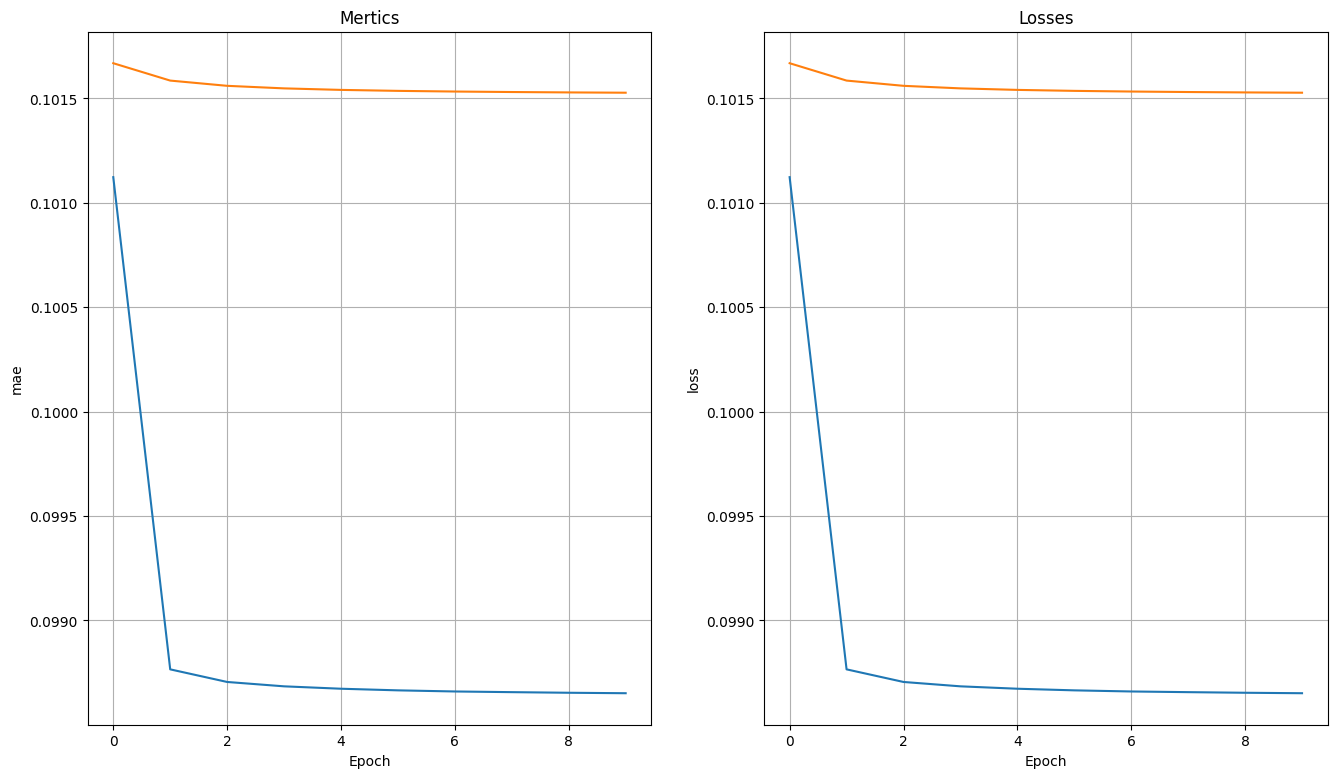

CPU times: user 9min 3s, sys: 13.3 s, total: 9min 16s
Wall time: 9min 42s


In [68]:
%%time
layers_grid = [[512, 256]]

nn_res = []

for layers in layers_grid:
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9)

    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

    nn_model = get_nn(features_train.shape[1], layers, output_neurons=1, output_act='sigmoid')
    nn_model.compile(optimizer=optimizer, loss='mae', metrics='mae')

    history = nn_model.fit(features_train, target_train, validation_data=(features_valid, target_valid),
                         epochs=10, verbose=1, callbacks=[stop])

    nn_prediction = nn_model.predict(features_valid)
    results = mean_absolute_error(nn_prediction.reshape(-1), \
                                torch.tensor(target_valid.values).type(torch.FloatTensor))
    print(f'Сеть {layers}, mae {results}')

    nn_res.append(['Dense with Dropout', layers, results])
    plt_result(history)

In [69]:
nn_res

[['Dense with Dropout', [512, 256], 0.101527244]]

In [70]:
df_results = pd.concat([df_results, pd.DataFrame(nn_res, columns=columns)]).reset_index(drop=True)

In [71]:
df_results

,model,Parametrs,metrics
0,Ridge,alpha=10,0.164170
1,Dense with Dropout,"[512, 256]",0.101527


Полносвязная нейронная сеть показала лучший результат, чем линейная регрессия. Для тестирования модели выбираем нейронную сеть.

# 7. Тестирование модели

In [73]:
datagen_test = ImageDataGenerator(rescale=1.0/255)

test_datagen_flow = datagen_test.flow_from_dataframe(
    dataframe = test_df,
    directory = os.path.join(DATA_PATH, 'test_images'),
    x_col='image',
    target_size=(224, 224),
    class_mode=None,
    batch_size=32,
    shuffle=True,
    seed=1
)

Found 500 validated image filenames.


In [74]:
image_features_test = model_image.predict(test_datagen_flow)

16/16 [==============================] - 140s 8s/step


In [75]:
df_test_image_features = pd.concat([test_df, pd.DataFrame(image_features_test)], axis=1)
df_test_image_features.head()

,query_id,query_text,image,0,1,2,3,4,5,6,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,0.0,0.0,0.0,0.0,0.938550,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000665,0.0,0.0,1.842731,0.0,0.0
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg,0.0,0.0,0.0,0.0,1.099189,0.0,0.0,...,0.0,0.0,0.0,0.0,0.012423,0.0,0.0,2.220727,0.0,0.0
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg,0.0,0.0,0.0,0.0,1.305999,0.0,0.0,...,0.0,0.0,0.0,0.0,0.024077,0.0,0.0,1.954241,0.0,0.0
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg,0.0,0.0,0.0,0.0,1.200138,0.0,0.0,...,0.0,0.0,0.0,0.0,0.026776,0.0,0.0,1.810727,0.0,0.0
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg,0.0,0.0,0.0,0.0,1.329911,0.0,0.0,...,0.0,0.0,0.0,0.0,0.022601,0.0,0.0,1.950500,0.0,0.0


In [76]:
queries_for_test = df_test_image_features['query_text'].sample(10, random_state=1)
queries_for_test

304    Three riders wearing black jerseys jump their ...
340    A choir in red uniforms singing in front of a ...
47     A woman walks and a little boy walks to the si...
67       A group of people in a large yard toss a disc .
479    One person in a crowd of people , wearing a bl...
485    A little kid splashes around in the kiddie poo...
310    a boy in a blue top is jumping off some rocks ...
31     A man feeding a horse wearing a blue strapped ...
249              Two dogs playing together in the snow .
90                              A boy plays basketball .
Name: query_text, dtype: object

In [82]:
def testing_nn(text):
    print(f'Описание: {text}')
    for word in text.split():
        if word in block_words:
            return 'WARNING: This image is unavailable in your country in compliance with local laws.'
    Xids_test = vectorizer.transform([text]).toarray()
    best = 0
    best_index = 0
    pred_list = []

    for i in range(len(image_features_test)):

        features_test = pd.DataFrame(image_features_test[i]).T.merge(pd.DataFrame(Xids_test), left_index=True, \
                                                      right_index=True, suffixes=(None, '_t'))

        features_test.columns = features_test.columns.astype(str)
        target_pred_test = nn_model.predict(features_test)
        pred_list.append(target_pred_test[0])

        if target_pred_test > best:
            best = target_pred_test
            best_index = i

    print(f'Лучшая вероятность: {best}')
    print(f'Лучший индекс: {best_index}')
    print(f'Лучшее изображение:')
    img = mpimg.imread(os.path.join(DATA_PATH, 'test_images/') + df_test_image_features.image[best_index])
    imgplot = plt.imshow(img)
    plt.show()

Описание: Three riders wearing black jerseys jump their BMX bikes into the air .
1/1 [==============================] - 0s 25ms/step
Лучшая вероятность: [[3.7229463e-05]]
Лучший индекс: 104
Лучшее изображение:


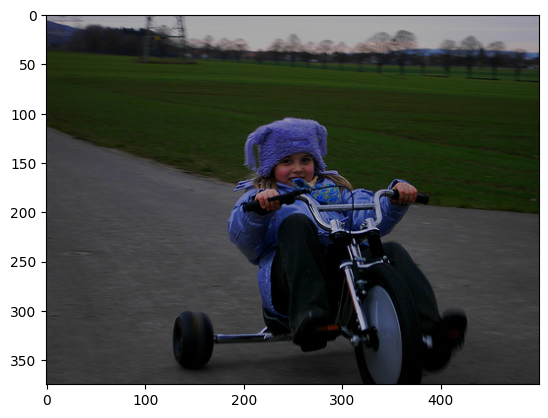

Описание: A choir in red uniforms singing in front of a business .
1/1 [==============================] - 0s 29ms/step
Лучшая вероятность: [[3.803921e-05]]
Лучший индекс: 104
Лучшее изображение:


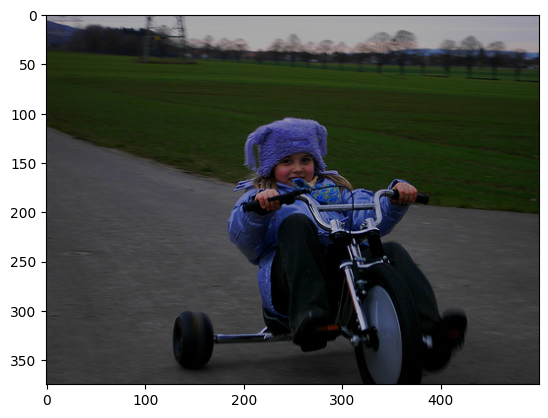

Описание: A woman walks and a little boy walks to the side of her .
Описание: A group of people in a large yard toss a disc .
1/1 [==============================] - 0s 25ms/step
Лучшая вероятность: [[3.6728536e-05]]
Лучший индекс: 104
Лучшее изображение:


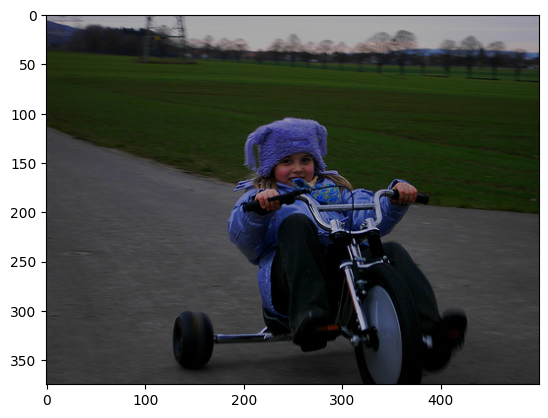

Описание: One person in a crowd of people , wearing a blue wig
1/1 [==============================] - 0s 29ms/step
Лучшая вероятность: [[3.6408164e-05]]
Лучший индекс: 104
Лучшее изображение:


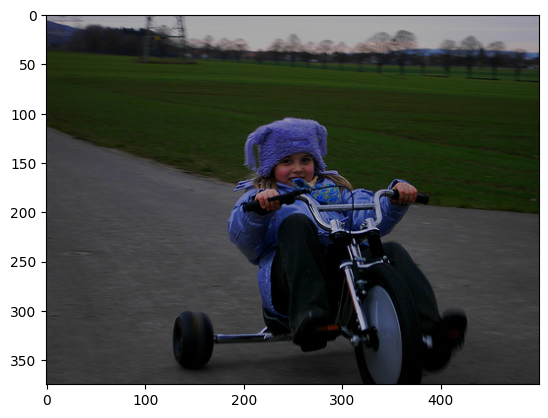

Описание: A little kid splashes around in the kiddie pool while a lady watches .
Описание: a boy in a blue top is jumping off some rocks in the woods .
Описание: A man feeding a horse wearing a blue strapped blanket .
1/1 [==============================] - 0s 31ms/step
Лучшая вероятность: [[3.6510453e-05]]
Лучший индекс: 104
Лучшее изображение:


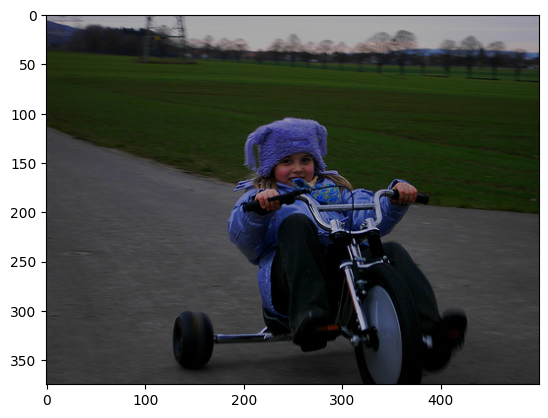

Описание: Two dogs playing together in the snow .
1/1 [==============================] - 0s 26ms/step
Лучшая вероятность: [[3.6391397e-05]]
Лучший индекс: 104
Лучшее изображение:


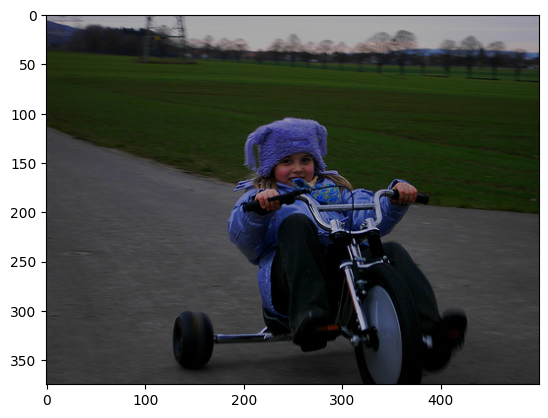

Описание: A boy plays basketball .


In [83]:
for string in queries_for_test:
    testing_nn(string)

Общий вывод - проект по созданию сервиса поиска фотографий по текстовому описанию можно осуществить с помощью сложных нейронных сетей, однако обучать модель необходимо на большем количестве качественно размеченных данных. Большинство изображений не соответсвуют описанию.

**Вывод**:

- загрузили и первично изучии данные, предложенные для анализа;
- провели исследовательский анализ полученных данных, объединили данные в общий датасет;
- удалили описания и изображения, попадающие под ограничения законодательства;
- векторизовали изображения с помощью ResNet50;
- векторизовали текстовые описания с помощью BERT;
- обучили модель линейной регрессии и полносвязную нейронную сеть и получили следующие результаты: *MAE линейной регрессии – 0.164170, MAE нейронной сети – 0.101527*

После обучения модели мы проверили ее работу, получив для 10 случайных изображений наиболее подходящие изображения, однако большинство изображений не соответствуют описанию.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x] Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска